In [1]:
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt

# vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp

# svd
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD

# kmeans
from sklearn.cluster import KMeans

### 1. Load data

In [2]:
processed_train_data = pd.read_pickle("../Preprocessing/Data/train_processed.pkl")
processed_eval_data = pd.read_pickle("../Preprocessing/Data/eval_processed.pkl")

### 2. Vectorize texts

To vectorize, one uses TF-IDF weighting of token features. Furthermore, one keeps only 20000 words in the dictionnary.

In [3]:
n_features = 20000 # size of the dictionary

In [4]:
corpus = processed_train_data['clean_text']

In [5]:
# low value of max_df: try to remove very common words
vectorizer = TfidfVectorizer(max_df=0.2, min_df=2, stop_words='english', max_features = n_features)
raw_vect_texts = vectorizer.fit_transform(corpus)

In [6]:
print(f'Number of features kept: {len(vectorizer.get_feature_names()):0}')

Number of features kept: 20000


In [7]:
print(vectorizer.get_feature_names())

['00', '000', '000s', '001', '002', '004', '006', '007', '008', '00am', '00pm', '01', '019', '02', '020', '022', '023', '027', '029', '03', '0300', '032', '033', '035', '038', '04', '042', '043', '049', '05', '056', '06', '061', '064', '067', '07', '071', '073', '074', '075', '079', '08', '0800', '0808', '087', '088', '09', '092', '095', '097', '10', '100', '1000', '10000', '100000', '1008', '100daysofcode', '100k', '100m', '100th', '101', '102', '103', '104', '105', '106', '107', '1075', '108', '109', '10am', '10downingstreet', '10k', '10m', '10pm', '10th', '10x', '11', '110', '1100', '111', '112', '113', '114', '115', '116', '117', '118', '119', '11am', '11k', '11mai', '11pm', '11th', '11thhour', '12', '120', '1200', '121', '122', '122k', '123', '124', '125', '126', '127', '128', '129', '12k', '12news', '12pm', '12th', '13', '130', '1300', '131', '132', '133', '134', '135', '136', '137', '138', '139', '13k', '13th', '14', '140', '1400', '141', '142', '143', '144', '145', '146', '147'

In [8]:
raw_vect_texts.get_shape()

(665777, 20000)

### 3. Dimensionality reduction

The number of dimensions is too big ; therefore one will first use  to reduce dimensionality.

In [9]:
n_components = 800 # number of components kept for PCA
                    # 100 components more cost around 25s

In [10]:
svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [11]:
# WARNING : may be extremely long to compute
# 1' 40" for 500 components out of all the tweets
# number of features has almost no impact
t0 = time()
svd_vect_texts = lsa.fit_transform(raw_vect_texts)
print(f'Done in {time() - t0:.3f}s')
print(f'Initial number of components: {raw_vect_texts.shape[1]:0}')
print(f'Final number of components: {n_components:0}')

Done in 263.357s
Initial number of components: 20000
Final number of components: 800


In [12]:
svd_vect_texts.shape

(665777, 800)

In [13]:
explained_variance = svd.explained_variance_ratio_.sum()
print("explained variance: %0.3f" % explained_variance)

explained variance: 0.451


### 4. Use Kmeans to clusterize

In [14]:
from sklearn.cluster import KMeans

##### Find the good number of clusters : elbow method

In [ ]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    t0 = time()
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    km = km.fit(svd_vect_texts)
    Sum_of_squared_distances.append(km.inertia_)
    print(f'Step {k:2d} done in {time() - t0:.3f}s')

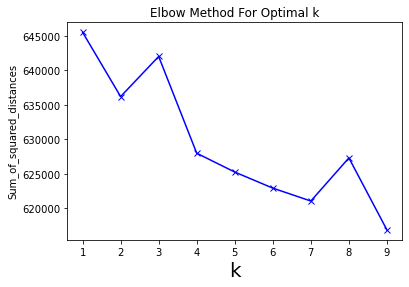

In [16]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k', fontsize = 20)
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The optimal number of clusters seems to be 7

##### Train classifier

In [17]:
n_clusters = 7 # final number of clusters

In [18]:
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, verbose=False)

In [19]:
t0 = time()
km.fit(svd_vect_texts)
print(f'Done in {time() - t0:.3f}s')

Done in 22.771s


- Reduce dimension on the dictionary of size n_features
- svd.transform to map to the kmeans space
- kmeans.predict to get the cluster

##### Predict cluster on train set

In [20]:
sample = svd.transform(raw_vect_texts)

In [21]:
sample.shape

(665777, 800)

In [22]:
clusters = km.predict(sample)

In [23]:
clusters.shape

(665777,)

In [24]:
processed_train_data['text_cluster'] = clusters

In [25]:
processed_eval_data.shape

(285334, 18)

##### Predict cluster on eval set

In [26]:
eval_corpus = processed_eval_data['text']

In [27]:
train_vocab = vectorizer.get_feature_names() # use the same vocab to vectorize
evalVectorizer = TfidfVectorizer(max_features = n_features, vocabulary = train_vocab)

In [28]:
raw_vect_eval = evalVectorizer.fit_transform(eval_corpus)

In [29]:
raw_vect_eval.shape

(285334, 20000)

In [30]:
vect_eval = svd.transform(raw_vect_eval)

In [31]:
vect_eval.shape

(285334, 800)

In [32]:
eval_clusters = km.predict(vect_eval)

In [33]:
processed_eval_data['text_cluster'] = eval_clusters

### 5. Display Results

##### Cluster distribution on training set

In [34]:
clusters_count_train = np.zeros(n_clusters)
for i in range(n_clusters):
    clusters_count_train[i] = processed_train_data[processed_train_data['text_cluster'] == i].shape[0]

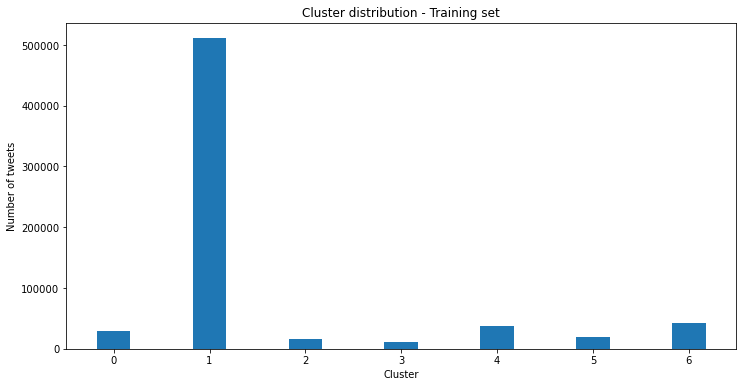

In [35]:
fig, ax = plt.subplots(figsize = (12,6))

width = 0.35

x = np.arange(n_clusters)

rect = ax.bar(x, clusters_count_train, width)

# X #
ax.set_xlabel("Cluster")

# Y #
ax.set_ylabel("Number of tweets")

ax.set_xticks(x)
ax.set_xticklabels(np.arange(n_clusters))

ax.set_title("Cluster distribution - Training set")

plt.show()

##### Cluster distribution on training set

In [36]:
clusters_count_eval = np.zeros(n_clusters)
for i in range(n_clusters):
    clusters_count_eval[i] = processed_eval_data[processed_eval_data['text_cluster'] == i].shape[0]

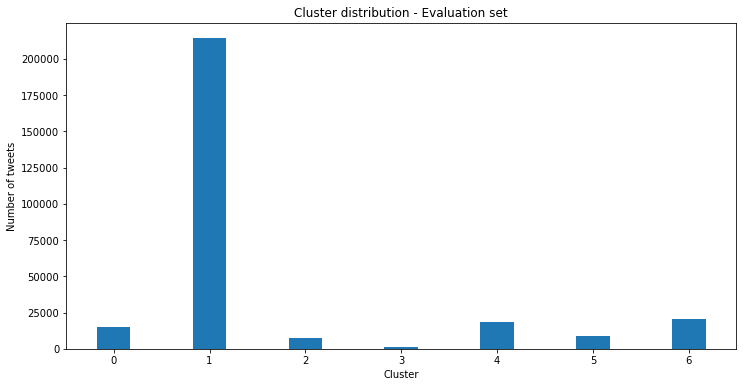

In [37]:
fig, ax = plt.subplots(figsize = (12,6))

width = 0.35

x = np.arange(n_clusters)

rect = ax.bar(x, clusters_count_eval, width)

# X #
ax.set_xlabel("Cluster")

# Y #
ax.set_ylabel("Number of tweets")

ax.set_xticks(x)
ax.set_xticklabels(np.arange(n_clusters))

ax.set_title("Cluster distribution - Evaluation set")

plt.show()

###### Try to qualitatively infer the meaning of clusters

In [38]:
km.cluster_centers_.shape

(7, 800)

In [39]:
centroids = svd.inverse_transform(km.cluster_centers_)
centroids.shape

(7, 20000)

In [40]:
train_vocab = vectorizer.get_feature_names()
len(train_vocab)

20000

In [41]:
for i, centroid in enumerate(centroids):
    print(f'Cluster {i:0} keywords: ')
    
    topTen = centroid.argsort()[-10:][::-1]
    keyWords = ""
    for rank in topTen:
        keyWords += train_vocab[rank]+" ; "
    print(keyWords)

Cluster 0 keywords: 
covid19 ; amp ; coronavirus ; help ; people ; health ; time ; support ; need ; new ; 
Cluster 1 keywords: 
people ; trump ; need ; time ; know ; right ; say ; great ; let ; want ; 
Cluster 2 keywords: 
pandemic ; going ; coronavirus ; covid19 ; people ; world ; trump ; new ; global ; time ; 
Cluster 3 keywords: 
case ; new ; covid ; 19 ; death ; coronavirus ; confirmed ; total ; number ; covid19 ; 
Cluster 4 keywords: 
coronavirus ; trump ; people ; death ; new ; lockdown ; say ; china ; time ; amp ; 
Cluster 5 keywords: 
like ; good ; look ; news ; coronavirus ; people ; sound ; feel ; thing ; time ; 
Cluster 6 keywords: 
covid ; 19 ; pandemic ; amp ; people ; death ; coronavirus ; patient ; new ; crisis ; 


### 6. Save clusters

In [42]:
train_title = f'train_text_{n_features:0}_{n_components:0}_{n_clusters:0}.pkl'
train_title

'train_text_20000_800_7.pkl'

In [43]:
eval_title = f'eval_text_{n_features:0}_{n_components:0}_{n_clusters:0}.pkl'
eval_title

'eval_text_20000_800_7.pkl'

In [44]:
processed_train_data['text_cluster'].to_pickle("Data/"+train_title)

In [45]:
processed_eval_data['text_cluster'].to_pickle("Data/"+eval_title)